In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emachine as EM

from sklearn.preprocessing import OneHotEncoder

In [2]:
np.random.seed(0)

In [3]:
s0 = np.loadtxt('s0.txt')
s0.shape

(2000, 10)

In [4]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
s = onehot_encoder.fit_transform(s0)
s.shape

(2000, 30)

In [5]:
n = 10; m = 3
mx = np.array([m for i in range(n)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

In [6]:
mx.sum()

30

In [7]:
n_seq = s.shape[0]

In [8]:
n_ops = int((m**2)*n*(n-1)/2.)
ops = np.zeros((n_seq,n_ops))
ij_tab = np.zeros((n_ops,2))

mx_sum = mx.sum()
   
ij = 0
for i0 in range(n-1):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]
    for i in range(i1,i2):
        for j in range(i2,mx_sum):
            ops[:,ij] = s[:,i]*s[:,j]
            
            ij_tab[ij,0] = i
            ij_tab[ij,1] = j
            
            ij += 1
print(ops.shape,ij)

(2000, 405) 405


In [9]:
# convert 1,0 to 1,-1
#ops = 2*ops - 1

In [10]:
#ops = np.zeros((n_seq,2)) # initial 2D array to use np.hstack
#for i0 in range(n-1):
#    i1,i2 = i1i2[i0,0],i1i2[i0,1]
#    for i in range(i1,i2):
#        for j in range(i2,mx_sum):
#            sij = s[:,i]*s[:,j]            
#            ops = np.hstack([ops,sij[:,np.newaxis]])      
#ops = ops[:,2:]  # delete the inital ops
#print(ops.shape)          

In [11]:
eps_list = np.linspace(0.9,1.0,11)
E_eps = np.zeros(len(eps_list))
w_eps = np.zeros((len(eps_list),ops.shape[1]))
for i,eps in enumerate(eps_list):
    w_eps[i,:],E_eps[i] = EM.fit(ops,eps=eps,max_iter=100)
    print(eps,E_eps[i])

0.9 -8.98884854324458
0.91 -8.939518979307111
0.92 -8.892502478094377
0.93 -8.847822660289502
0.9400000000000001 -8.805514069209767
0.95 -8.765624343497006
0.96 -8.728217203567572
0.97 -8.69337657106594
0.98 -8.661212270084361
0.99 -8.631867938099148
1.0 -8.605532016288308


In [12]:
w = w_eps[np.argmax(E_eps)]

In [13]:
w0 = np.loadtxt('w0.txt')

#w_true = np.zeros(ops.shape[1])
#ij = 0
#for i0 in range(n-1):
#    i1,i2 = i1i2[i0,0],i1i2[i0,1]
#    for i in range(i1,i2):
#        for j in range(i2,mx_sum):
#            w_true[ij] = w0[i,j]
#            ij += 1

In [14]:
w_pred = np.zeros((w0.shape[0],w0.shape[0]))

for ij in range(n_ops):
    w_pred[int(ij_tab[ij,0]),int(ij_tab[ij,1])] = w[int(ij)]  

In [15]:
for i in range(n):        
    i1,i2 = i1i2[i,0],i1i2[i,1]             
    w_pred[:,i1:i2] -= w_pred[:,i1:i2].mean(axis=1)[:,np.newaxis]

In [16]:
w_pred = w_pred + w_pred.T  

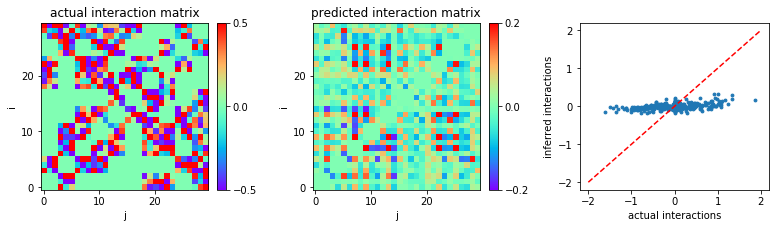

In [19]:
plt.figure(figsize=(11,3.2))

plt.subplot2grid((1,3),(0,0))
plt.title('actual interaction matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.xticks(np.arange(0, 30, 10))
plt.yticks(np.arange(0, 30, 10))
plt.clim(-0.5,0.5)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.5,0,0.5])

plt.subplot2grid((1,3),(0,1))
plt.title('predicted interaction matrix')
plt.imshow(w_pred,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.xticks(np.arange(0, 30, 10))
plt.yticks(np.arange(0, 30, 10))
plt.clim(-0.2,0.2)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.2,0,0.2])

plt.subplot2grid((1,3),(0,2))
plt.plot([-2,2],[-2,2],'r--')
plt.scatter(np.triu(w0),np.triu(w_pred),s=8)
plt.xlabel('actual interactions')
plt.ylabel('inferred interactions')

plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('w.pdf', format='pdf', dpi=100)